In [1]:
from utils_cv import *

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
import collections
import time
from skimage import io
from skimage.feature import canny
from skimage.transform import rescale
from skimage.morphology import dilation, disk
import scipy 
import skimage

from IPython.display import Image as Image_print


from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import imutils

from tqdm import tqdm_notebook as tqdm

import time

%matplotlib inline

from IPython import display

from scipy.ndimage import distance_transform_edt

1. Problem description. 8 points

Why is it important (innovation / research / fun)?
What's the expected value of your CV algorithm?
Dataset description with examples.
2. CV algorithm (slides). 8 points.

Describe the overall CV pipeline suitable to solve the problem.
Provide your motivation for each step of the pipeline.
You can compare more than one pipeline (e.g., try 2-3 different methods within a specif step).
3. CV algorithm (code). 8 points.

Are the tools applied correctly?
4. Results. 10 points. 

Estimate quality metrics (number of false positives / false negatives, mean errors for objects counts, etc.).
Compare methods (e.g., modifications of your pipeline or your pipeline versus an external baseline).
Provide good examples of the obtained results (don't forget to use a separate test set if you train a supervised algorithm).
Provide bad examples. Why does your algorithm fail? How can we improve it?
5. Presentations structure & clarity. 6 points.

# Measuring sizes of objects on video
### Project for Introduction to CV course

Created by Anton Bozhedarov and Polina Pilyugina
    


# Problem description

How to measure a size of an object, when you do not have a ruler with you?

<img src="problem.png" style="width: 450px;"/>

We propose a Computer Vision algorithm for this purpose! 

<img src="solution.png" style="width: 500px;"/>

# Solution and value
<img src="pipeline.png" style="width: 800px;"/>

## Start from sample images

For the first iteration and tuning of the algorithm we took a sample video and some sample images, in order to create and test the initial pipeline.

The idea is as follows:
1. A countour of size A1 with black edges is placed on a table
2. Frames are processed and treated as images
3. Image is downscaled and Canny algorithm is applied to it in order to extract the largest countour, which is the black countour of our A1 paper
4. Based on this countour the corners of the A1 rectangular are extracted
5. Perspective transform is applied to an image, in order to have only the insides of the A1 countour on the further images
6. Filtering is applied to an image in order to make edges more obvious and Canny is applied afterwards to extract all countours of objects inside the A1 rectangular
7. For each countour min area rectangular is found, outlining this countour, and a box is drawn based on it
8. Euclidean distances between corners are calculated
9. Distances are converted to real sizes, based on the size of the whole image, which is in real life equal to A1
10. Boxes and distances are plotted on the original image
11. Contours are converted with the inverse perspective transform
12. Final image is show as output

One of sample images


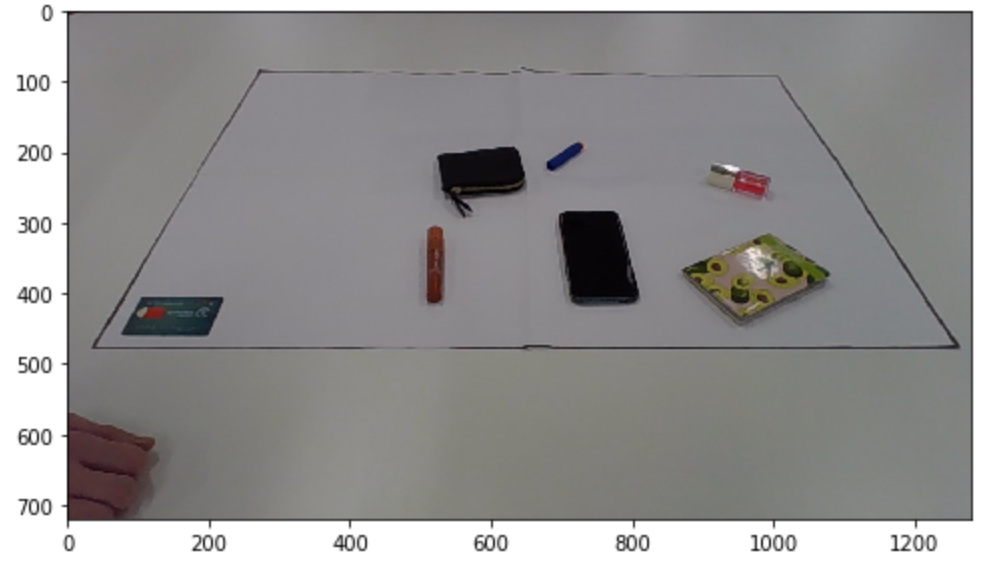

In [3]:
print('One of sample images')
Image_print(filename='sample_image.png', width = 500)

Example of Canny applied to sample image


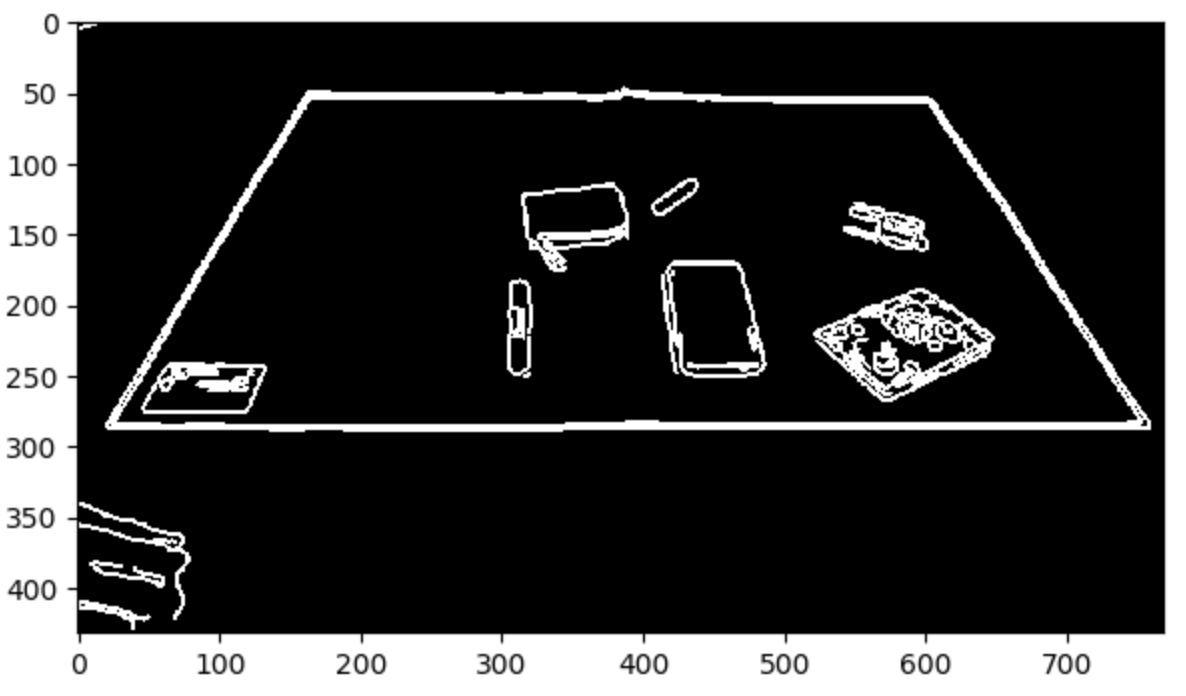

In [4]:
print('Example of Canny applied to sample image')
Image_print(filename='edges_big.png', width = 500)

Corners of rectangular extracted


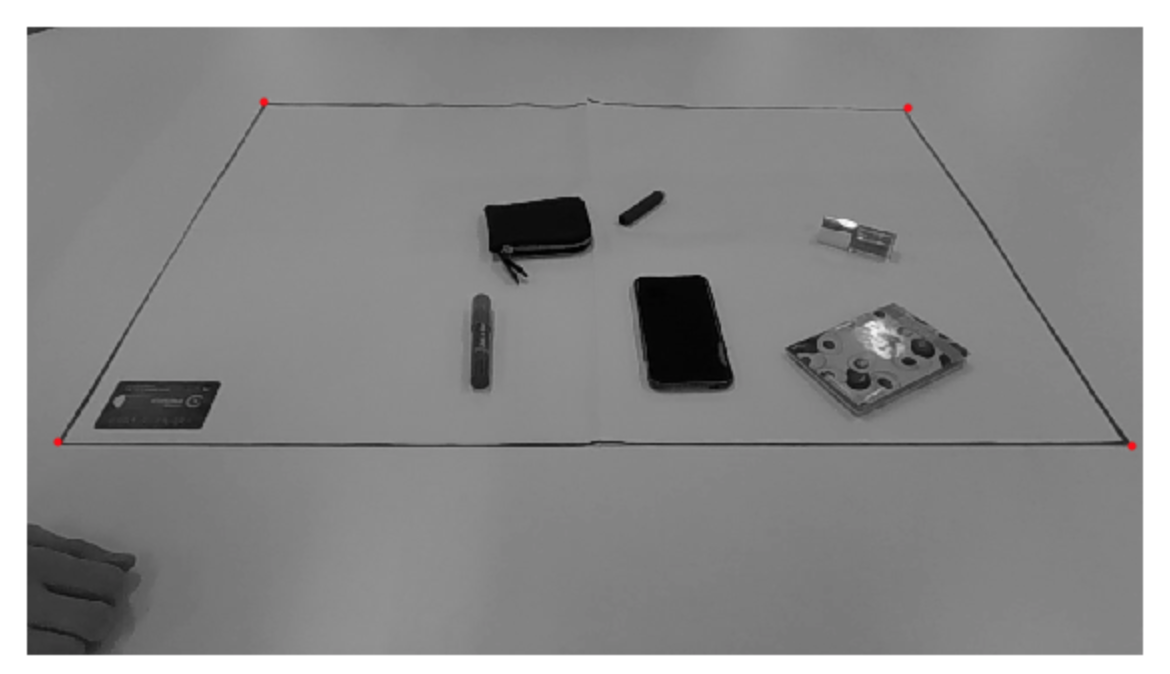

In [5]:
print('Corners of rectangular extracted')
Image_print(filename='corners.png', width = 500)

Reconstructed image


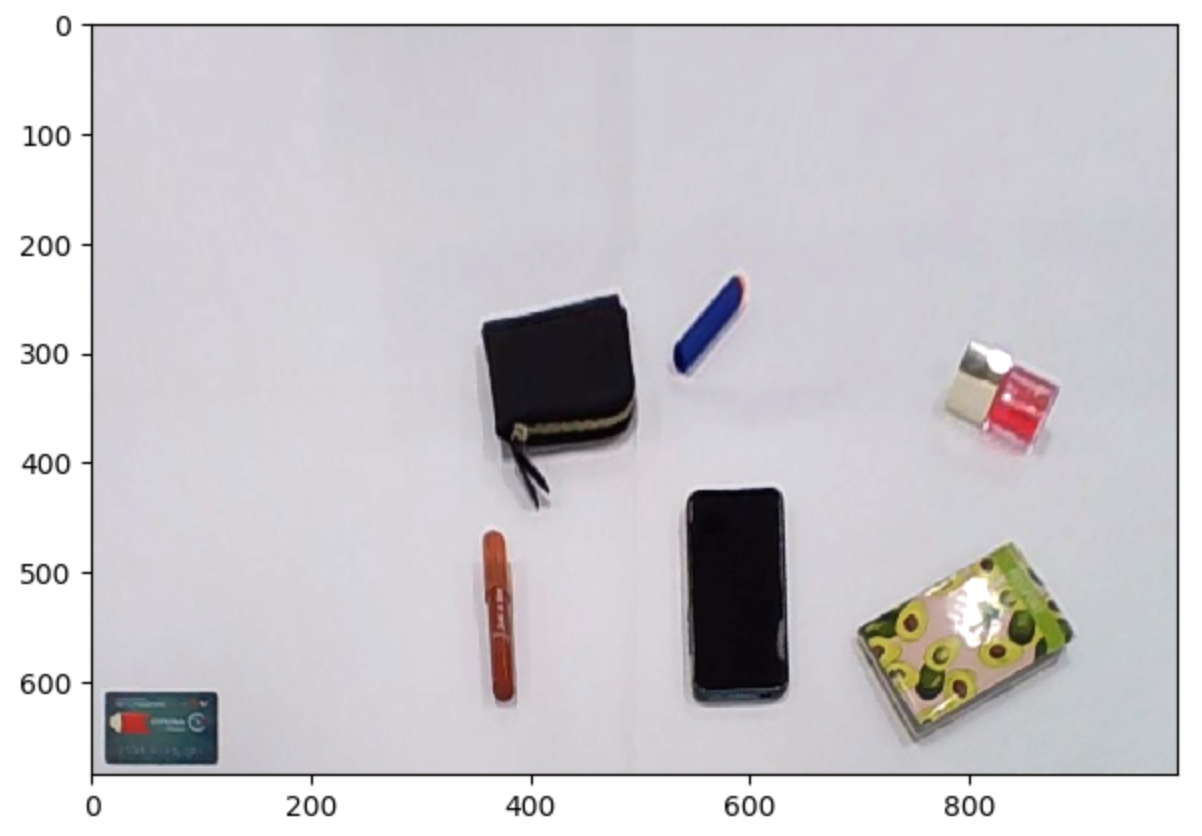

In [6]:
print('Reconstructed image')
Image_print(filename='reconstructed_image.png', width = 500)

In [18]:
files = np.array(os.listdir('data/'))
index = ['.jpg' in i for i in files]
paths = ['data/'+i for i in files[index]]

In [19]:
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in read_images(paths)]

In [20]:
grayscale_images = [cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY) for i in range(len(images))]

In [10]:
len(images)

5

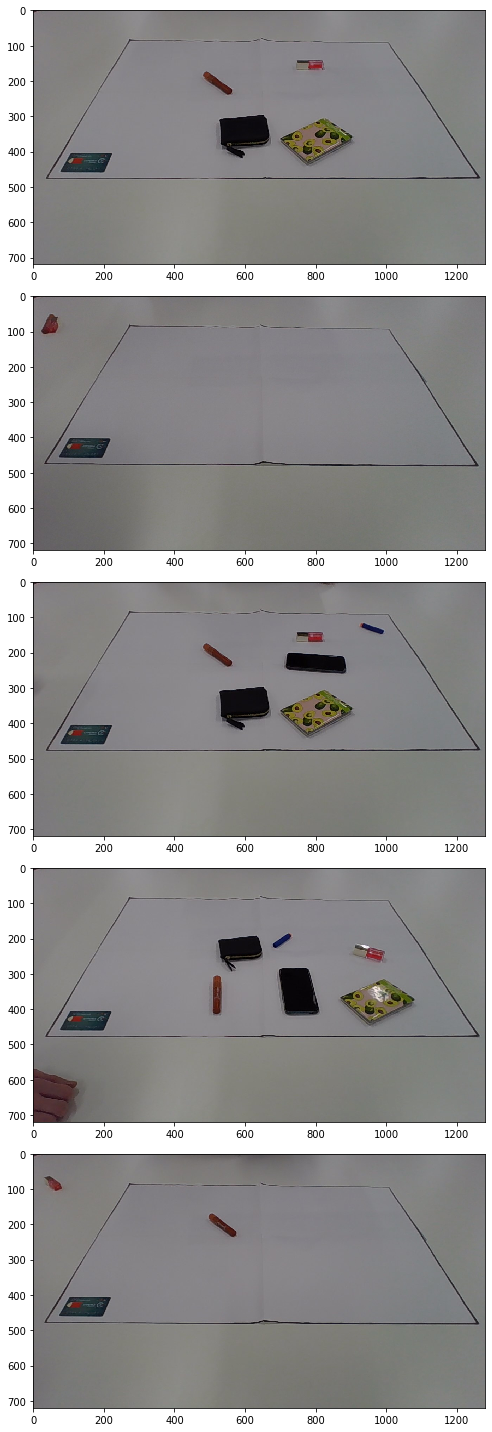

In [11]:
print_images(images, 5, 1)

### Image normalization

In [12]:
def normalize_image(image, image_colored, rescale_param = 0.5):
    image_scaled = rescale(image, rescale_param)
    edges = canny(image_scaled)
    
    selem = disk(1)
    edges = dilation(edges, selem)
    
    edges = (edges).astype(np.uint8)
    img, ext_contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#     show(img)
    contour = max(ext_contours, key=cv2.contourArea)    
    contour = contour.squeeze()
    
    epsilon = 0.05 * cv2.arcLength(contour, True)
    corners = cv2.approxPolyDP(contour, epsilon, True).squeeze()
    corners = (perspective.order_points(corners))
    corners = corners/rescale_param

#     plt.figure(figsize = (4, 4), dpi = 180)
#     plt.imshow(image, cmap = 'gray')
#     for i in range(len(corners)):
#         plt.scatter(corners[i][0], corners[i][1], c = 'r', s = 0.4)
#     plt.axis('off')
    
    size_square = min(image_scaled.shape)
    tform = ProjectiveTransform()
    tform.estimate(np.array([[0,0], [1020,0], [1020,720], [0, 720]]), corners)
    image_warped = warp(image_colored, tform)[:720,:1020]

    data = image_warped.astype('float64') / np.max(image_warped)
    data = 255 * data
    img = data.astype('uint8')
    img = adjusting_brightness(img[30:-5, 15:-15], a = 1.7, b = 3)
    return img, tform

In [13]:
n = 3
image_redone, _ = normalize_image(grayscale_images[n], images[n], rescale_param = 0.6)

/Users/polina/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


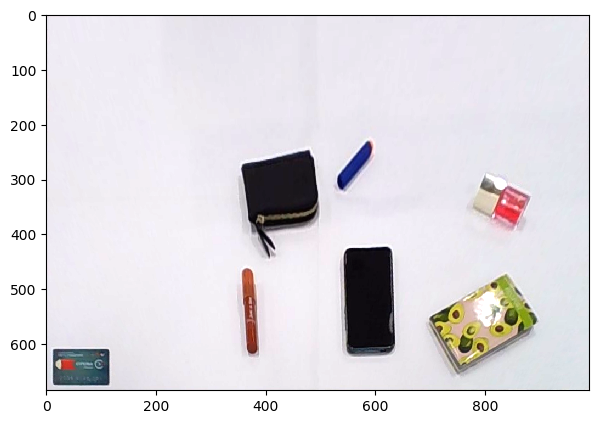

In [14]:
show(image_redone)

### Extraction of internal corners

In [39]:

image_redone, _ = normalize_image(grayscale_images[n], images[n], rescale_param = 0.6)
image = cv2.cvtColor(image_redone, cv2.COLOR_RGB2GRAY)

threshold = skimage.filters.threshold_otsu(image)
predicted = np.uint8(image > 200) * 255

gray = cv2.GaussianBlur(predicted, (7, 7), 0)

edged = cv2.Canny(gray, 50, 100)
edged = cv2.dilate(edged, None, iterations=2)
edged = cv2.erode(edged, None, iterations=1)
 
img, ext_contours, hierarchy = cv2.findContours(edged.copy(),
                                                cv2.RETR_EXTERNAL,
                                                cv2.CHAIN_APPROX_SIMPLE)

(cnts, _) = contours.sort_contours(ext_contours)
cnts = [cnt[:, 0] for cnt in cnts]
pixelsPerMetric = None

result = normalize_image(grayscale_images[n], images[n], rescale_param = 0.6)[0]
for c in cnts:
    if cv2.contourArea(c) < 100:
        continue
    box = cv2.boxPoints(cv2.minAreaRect(c)).astype('int32')
    box = perspective.order_points(box).astype('int32')
    cv2.drawContours(result, [box], -1, (255, 0, 116), 2)

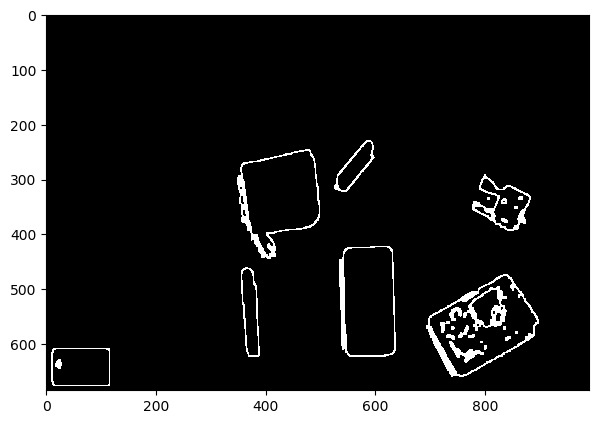

In [40]:
show(img)

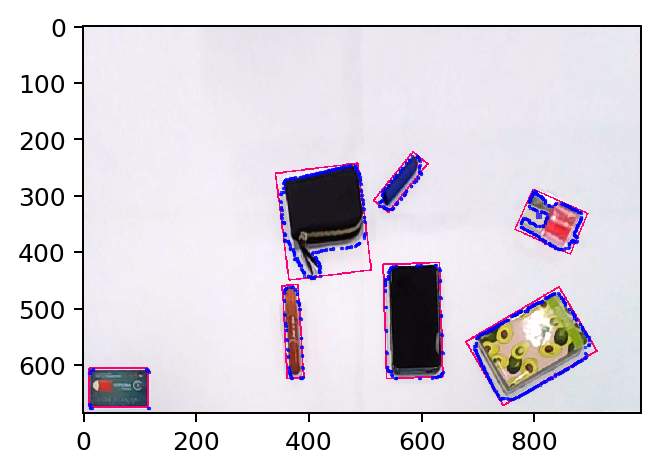

In [41]:
plt.figure(figsize = (4, 4), dpi = 180)
plt.imshow(result)
for i in range(len(cnts)):
    plt.scatter(cnts[i][:, 0], cnts[i][:, 1], c = 'b', s = 0.1)

In [44]:
def pipeline(original):
    def middle(x, y):
        return ((x[0]+y[0])/2, (x[1]+y[1])/2)
    
    image_redone, tform = normalize_image(cv2.cvtColor(original, cv2.COLOR_RGB2GRAY),
                                   original,
                                   rescale_param = 0.6)
    
    gray = cv2.cvtColor(image_redone,
                         cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 0)

    edged = cv2.Canny(gray, 50, 100)
    edged = cv2.dilate(edged, None, iterations=2)
    edged = cv2.erode(edged, None, iterations=1)

    img, ext_contours, hierarchy = cv2.findContours(edged.copy(),
                                                    cv2.RETR_EXTERNAL,
                                                    cv2.CHAIN_APPROX_SIMPLE)

    (cnts, _) = contours.sort_contours(ext_contours)
    cnts = [cnt[:, 0] for cnt in cnts]
    pixelsPerMetric = None

    result = image_redone.copy()
    for c in cnts:
        if cv2.contourArea(c) < 100:
            continue

        box = cv2.boxPoints(cv2.minAreaRect(c)).astype('int32')
        box = perspective.order_points(box).astype('int32')
        cv2.drawContours(result, [box], -1, (255, 0, 116), 2)

        top_left, top_right, bottom_right, bottom_left = box

        top_x, top_y = middle(top_left, top_right)
        bottom_x, bottom_y = middle(bottom_left, bottom_right)
        left_x, left_y = middle(top_left, bottom_left)
        right_x, right_y = middle(top_right, bottom_right)

        distance_1 = dist.euclidean((top_x, top_y), (bottom_x, bottom_y))
        distance_2 = dist.euclidean((left_x, left_y), (right_x, right_y))

        dimA = distance_2 * 0.076
        dimB = distance_1 * 0.076


        cv2.circle(result, (int(top_x), int(top_y)), 5, (255, 0, 0), -1)
        cv2.putText(result, "{:.1f} cm".format(dimA),
            (int(top_x - 10), int(top_y - 10)), 0, 0.65, (255, 0, 0), 2)

        cv2.circle(result, (int(right_x), int(right_y)), 5, (255, 0, 0), -1)
        cv2.putText(result, "{:.1f} cm".format(dimB),
            (int(right_x + 5), int(right_y)), 0, 0.65, (255, 0, 0), 2)
        
    return result

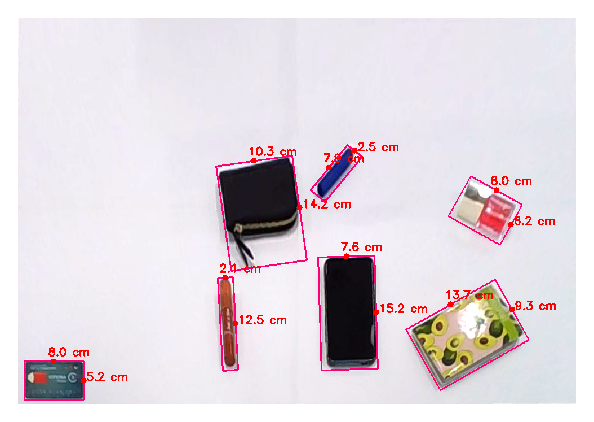

In [45]:
plt.figure(figsize = (4, 4), dpi = 180)
plt.imshow(pipeline(images[3]))
plt.axis('off')
plt.show()

In [62]:
def pipeline_j(original):
    def middle(x, y):
        return ((x[0]+y[0])/2, (x[1]+y[1])/2)
    try:
        image_redone, tform = normalize_image(cv2.cvtColor(original, cv2.COLOR_RGB2GRAY),
                                   original,
                                   rescale_param = 0.6)
    except:
        return None
    result = np.zeros(image_redone.shape)
    
    median_filtered = scipy.ndimage.median_filter(cv2.cvtColor(image_redone, cv2.COLOR_RGB2GRAY ), size=3)

    threshold = skimage.filters.threshold_otsu(median_filtered)
    predicted = np.uint8(median_filtered > 220) * 255
    gray = cv2.GaussianBlur(median_filtered, (7, 7), 0)

    edged = cv2.Canny(gray, 50, 100)
    edged = cv2.dilate(edged, None, iterations=2)
    edged = cv2.erode(edged, None, iterations=1)

    img, ext_contours, hierarchy = cv2.findContours(edged.copy(),
                                                    cv2.RETR_EXTERNAL,
                                                    cv2.CHAIN_APPROX_SIMPLE)

    (cnts, _) = contours.sort_contours(ext_contours)
    cnts = [cnt[:, 0] for cnt in cnts]
    pixelsPerMetric = None

    
    for c in cnts:
        if cv2.contourArea(c) < 200:
            continue

        box = cv2.boxPoints(cv2.minAreaRect(c)).astype('int32')
        box = perspective.order_points(box).astype('int32')
        cv2.drawContours(result, [box], -1, (255, 0, 116), 10)

        top_left, top_right, bottom_right, bottom_left = box
        top_x, top_y = middle(top_left, top_right)
        bottom_x, bottom_y = middle(bottom_left, bottom_right)
        left_x, left_y = middle(top_left, bottom_left)
        right_x, right_y = middle(top_right, bottom_right)

        distance_1 = dist.euclidean((top_x, top_y), (bottom_x, bottom_y))
        distance_2 = dist.euclidean((left_x, left_y), (right_x, right_y))

        dimA = distance_2 * 0.076
        dimB = distance_1 * 0.076
        
#         cv2.circle(result, (int(top_left[0]), int(top_left[1])), 5, (255, 0, 0), -1)
#         cv2.circle(result, (int(top_right[0]), int(top_right[1])), 5, (255, 0, 0), -1)
#         cv2.circle(result, (int(bottom_right[0]), int(bottom_right[1])), 5, (255, 0, 0), -1)
#         cv2.circle(result, (int(bottom_left[0]), int(bottom_left[1])), 5, (255, 0, 0), -1)

#         cv2.circle(result, (int(top_x), int(top_y)), 5, (255, 0, 0), -1)
#         cv2.putText(result, "{:.1f} cm".format(dimA),
#             (int(top_x - 10), int(top_y - 10)), 0, 0.65, (255, 0, 0), 2)

#         cv2.circle(result, (int(right_x), int(right_y)), 5, (255, 0, 0), -1)
#         cv2.putText(result, "{:.1f} cm".format(dimB),
#             (int(right_x + 5), int(right_y)), 0, 0.65, (255, 0, 0), 2)
        
    result = np.pad(result, ((30,5), (15, 15), (0,0)), mode='constant') #pading is the same KOSTYL as before
    
    result = warp(result, tform.inverse, output_shape=original.shape)
    result = result.astype('uint8')
    
    mask = np.nonzero(result[:,:,0])
    
    # render borders on original image 
    a = original.copy()
    a[mask] = [200, 0, 0]
    
    show(a)
    
    return result

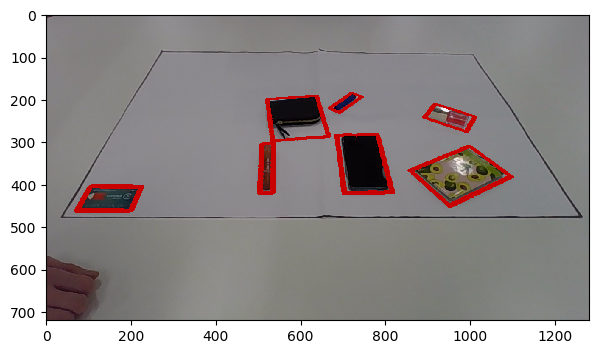

In [63]:
h = pipeline_j(images[3])

In [56]:
np.where(h != 0)[1]

array([716, 717, 718, ...,  70, 197, 198])

In [ ]:
cv2.drawContours(result, [box], -1, (255, 0, 116), 2)

<Figure size 900x900 with 0 Axes>

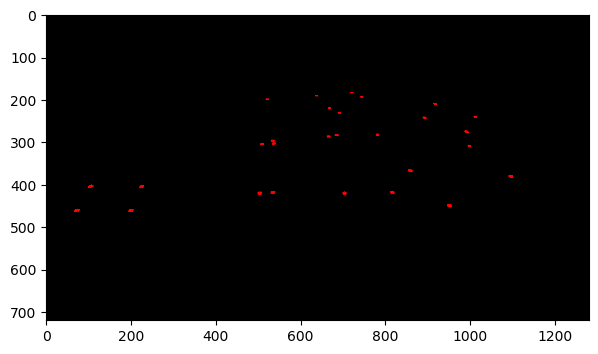

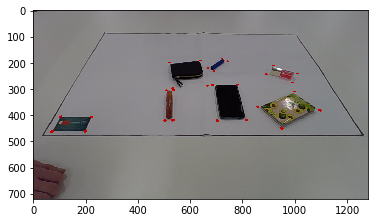

In [49]:
plt.figure(figsize = (5, 5), dpi = 180)
plt.imshow(pipeline_j(images[3]))
# plt.imshow((images[3]))
plt.show()

In [ ]:
cap = cv2.VideoCapture('data/video.mp4')
while(cap.isOpened()):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [70]:
# but this works somehow

video_capture = cv2.VideoCapture('data/video.mp4')
frames = []
# while video_capture.isOpened():
for i in tqdm(range(15000)):
#     if i%100 != 0:
#         continue
    ret, frame = video_capture.read()
    frames.append(frame)
#     if ret:
#         #cv2.imshow('Video', frame)
#         display.clear_output(wait=True)
#         frame = pipeline(frame)
#         plt.imshow(frame)
#         plt.show()
#         time.sleep(0.002)
        
#         k = cv2.waitKey(33) & 0xff
#         if  k == 27: 
#             break
#     else:
#         break
video_capture.release()
# cv2.destroyAllWindows()

In [85]:
img_array = []
for frame in tqdm(frames):
    frame = pipeline(frame)
    if type(frame) == type(None):
        continue
    img_array.append(frame)
#     display.clear_output(wait=True)
#     plt.imshow(frame)
#     plt.show()
#     time.sleep(0.002)

In [88]:
height, width, layers = img_array[0].shape

In [89]:
size = (width,height)

In [90]:
import cv2
import numpy as np
import glob


out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [81]:
type(None)

NoneType

In [94]:
# img = normalize_image(cv2.cvtColor(images[0], cv2.COLOR_RGB2GRAY),
#                                    images[0],
#                                    rescale_param = 0.6)
# gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


median_filtered = scipy.ndimage.median_filter(cv2.cvtColor(normalize_image(cv2.cvtColor(images[0],
                                                                                        cv2.COLOR_RGB2GRAY),
                                   images[0],
                                   rescale_param = 0.6),cv2.COLOR_RGB2GRAY ), size=3)
thresh = np.uint8(median_filtered > 220) * 255
ret = 160
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

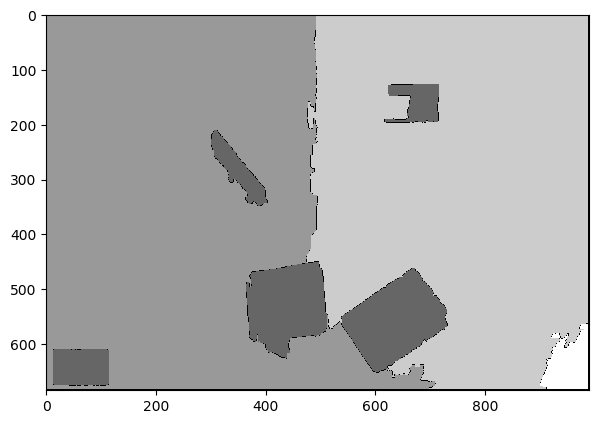

In [95]:
show(markers)

Text(0.5, 1.0, 'median filtered image')

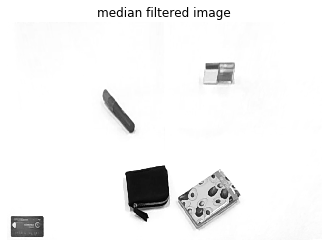

In [46]:
median_filtered = scipy.ndimage.median_filter(cv2.cvtColor(normalize_image(cv2.cvtColor(images[0],
                                                                                        cv2.COLOR_RGB2GRAY),
                                   images[0],
                                   rescale_param = 0.6),cv2.COLOR_RGB2GRAY ), size=3)
plt.imshow(median_filtered, cmap='gray')
plt.axis('off')
plt.title('median filtered image')

Text(0.5, 1.0, 'otsu predicted binary image')

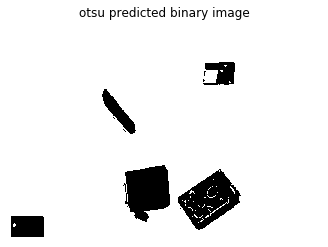

In [58]:
median_filtered = scipy.ndimage.median_filter(cv2.cvtColor(normalize_image(cv2.cvtColor(images[0],
                                                                                        cv2.COLOR_RGB2GRAY),
                                   images[0],
                                   rescale_param = 0.6),cv2.COLOR_RGB2GRAY ), size=3)

threshold = skimage.filters.threshold_otsu(median_filtered)
predicted = np.uint8(median_filtered > 220) * 255


In [5]:
# but this works somehow

video_capture = cv2.VideoCapture(0)
frames = []
# while video_capture.isOpened():
for i in range(10):
    ret, frame = video_capture.read()
    frames.append(frame)
    if ret:
        #cv2.imshow('Video', frame)
        display.clear_output(wait=True)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY), cmap = 'gray')
        plt.show()
        time.sleep(0.002)
        
        k = cv2.waitKey(33) & 0xff
        if  k == 27: 
            break
    else:
        break
video_capture.release()
# cv2.destroyAllWindows()